## Image Captioning
-  Generating captions for images

### Steps
- Data collection
- understanding the data
- data cleaning
- loading the training set
- data preprocessing - Images
- data preprocessing - captions
- data preparation using generator function
- word embeddings
- model architecture
- inference 
- evaluation

In [2]:
from keras.layers import *
import re
import pickle
from time import time
import string
from keras.applications.vgg16 import VGG16
from keras.utils import to_categorical
from keras.layers.merge import add
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image
import numpy as np
import pandas as pd
import json

In [3]:
# read text captions
def readTextfile(path):
    with open(path) as f:
        captions = f.read()
    return captions


In [4]:
captions = readTextfile("./Data/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split('\n')[:-1]

In [5]:
captions[-1]

'997722733_0cb5439472.jpg#4\tA rock climber practices on a rock climbing wall .'

In [6]:
# Dictionary to map each image id to its list of corresponding captions...

In [7]:
descriptions = {}
for i in range(len(captions)):
    test = captions[i].split('\t')
    img = test[0]
    img = img.split('.')[0]
    cap = test[1]
    if descriptions.get(img) is None:
        descriptions[img] = []
        
    descriptions[img].append(cap)
            

In [8]:
# Checking --> 
len(descriptions) == len(captions)/5


True

In [9]:
descriptions['997722733_0cb5439472']

['A man in a pink shirt climbs a rock face',
 'A man is rock climbing high in the air .',
 'A person in a red shirt climbing up a rock face covered in assist handles .',
 'A rock climber in a red shirt .',
 'A rock climber practices on a rock climbing wall .']

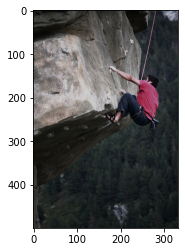

In [10]:
IMG_PATH = "./Data/Flickr_Data/Flickr_Data/Images/"
import cv2
import matplotlib.pyplot as plt
img = cv2.imread(IMG_PATH+"997722733_0cb5439472.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()


#### Data cleaning

In [11]:
# Cannot remove stopwords
# don't do stemming
# because we want grammatically correct caption
# remove number , punctuation and non-alphabets character
# to reduce vocab size

In [12]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence


In [13]:
clean_text("A cat is sitting over the house # 64")

'cat is sitting over the house'

In [14]:
# clean all caption
for key,caption_list in descriptions.items():
    descriptions[key] = [clean_text(cap) for cap in caption_list]
        

In [15]:
descriptions["997722733_0cb5439472"]

['man in pink shirt climbs rock face',
 'man is rock climbing high in the air',
 'person in red shirt climbing up rock face covered in assist handles',
 'rock climber in red shirt',
 'rock climber practices on rock climbing wall']

In [16]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [17]:
# Write the data to text file
with open('description.txt','w') as f:
    f.write(str(descriptions))


In [18]:
!ls


Data                   Untitled.ipynb         glove.6B.50d.txt
Image captioning.ipynb description.txt        images.jpeg


In [19]:
!gedit description.txt

zsh:1: command not found: gedit


#### Vocabulary

In [20]:
descriptions = None
with open('description.txt','r') as f:
    descriptions = f.read()

json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [21]:
print(type(descriptions))

<class 'dict'>


In [22]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [23]:
vocab = set()

for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

print("vocab size : %d"% len(vocab))

vocab size : 8424


In [24]:
# vocab
# remove words having frequency less than threshold

In [25]:
# Total no. of words across all the sentences
total_words = []
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]

In [26]:
print("Total words : %d"%len(total_words))

Total words : 373837


In [27]:
# filter words from the vocab according to certain threshold frequency
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
# print(freq_cnt)
# unique words -->
print(len(freq_cnt.keys()))

8424


In [28]:
# freq_cnt

In [29]:
# sort this dictionary according to the freq_count -->
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# filter -->
threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words =[x[0] for x in sorted_freq_cnt]

In [30]:
# sorted_freq_cnt
print(len(total_words))

1845


#### Prepare train/test data

In [31]:
train_file_data = readTextfile('./Data/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt')
test_file_data = readTextfile('./Data/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt')

In [32]:
train = [row.split(".")[0] for row in train_file_data.split('\n')[:-1]]
test = [row.split(".")[0] for row in test_file_data.split('\n')[:-1]]

In [33]:
test[:3]

['3385593926_d3e9c21170', '2677656448_6b7e7702af', '311146855_0b65fdb169']

In [34]:
# Prepare Description for the training data
# Tweak - Add <s> and <e> token to our training data
train_description = {}
for img_id in train:
    train_description[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq " + cap + " endseq"
        train_description[img_id].append(cap_to_append)

In [35]:
train_description['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

### Transfer learning
- Images --> features
- Text --> features

#### Step - 1 Image feature extraction

In [36]:
model = ResNet50(weights='imagenet',input_shape=(224,224,3))
# model.summary()

In [37]:
# model.layers[-2].output

In [38]:
model_new = Model(model.input,model.layers[-2].output) 

In [39]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    
    return img

In [40]:
# img = preprocess_img(IMG_PATH+"997722733_0cb5439472.jpg")

In [41]:
# plt.imshow(img[0])
# plt.show()

In [42]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [43]:
# encode_image(IMG_PATH+"997722733_0cb5439472.jpg")

In [44]:
encoding_train = {}
# image_id --> feature_vector extracted from ResNet Image
start_t = time()
for ix, img_id in enumerate(train):
    img_path = IMG_PATH+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100 ==0:
        print("Encoding in progress time step : %d"%ix)

end_t = time()

print("Time Taken: %d"%(start_t-end_t))
                                        

Encoding in progress time step : 0
Encoding in progress time step : 100
Encoding in progress time step : 200
Encoding in progress time step : 300
Encoding in progress time step : 400
Encoding in progress time step : 500
Encoding in progress time step : 600
Encoding in progress time step : 700
Encoding in progress time step : 800
Encoding in progress time step : 900
Encoding in progress time step : 1000
Encoding in progress time step : 1100
Encoding in progress time step : 1200
Encoding in progress time step : 1300
Encoding in progress time step : 1400
Encoding in progress time step : 1500
Encoding in progress time step : 1600


KeyboardInterrupt: 

In [ ]:
# store everything to the disk //
# encoding_train
with open('encoded_train_feature.pkl','wb') as f:
    pickle.dump(encoding_train,f)

In [ ]:
encoding_test = {}
# image_id --> feature_vector extracted from ResNet Image
start_t = time()
for ix, img_id in enumerate(test):
    img_path = IMG_PATH+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100 ==0:
        print("Encoding in progress time step : %d"%ix)

end_t = time()

print("Time Taken: %d"%(start_t-end_t))

with open('encoded_test_feature.pkl','wb') as f:
    pickle.dump(encoding_test,f)

In [ ]:
# Convert captions into features
# data preprocessing for captions -->


In [45]:
# Vocab 
len(total_words)

1845

In [46]:
words_to_idx = {}
idx_to_words = {}
for i,word in enumerate(total_words):
    words_to_idx[word] = i+1
    idx_to_words[i+1] = word

# Add two special words -->
idx_to_words[len(idx_to_words)+1] = 'startseq'
words_to_idx['startseq'] = len(idx_to_words)
idx_to_words[len(idx_to_words)+1] = 'endseq'
words_to_idx['endseq'] = len(idx_to_words)

In [47]:
words_to_idx['endseq'], idx_to_words[1847]

(1847, 'endseq')

In [48]:
vocab_size = len(words_to_idx) + 1
print("Vocab size : %d"%vocab_size)

Vocab size : 1848


In [49]:
max_len = 0
for key in train_description.keys():
    for caption_list in train_description[key]:
        max_len = max(max_len,len(caption_list.split()))

In [50]:
max_len

35

In [51]:
with open('word_to_idx.pkl','wb') as w2i:
    pickle.dump(words_to_idx,w2i)
    
with open('idx_to_word.pkl','wb') as i2w:
    pickle.dump(idx_to_words,i2w)

## Data loader (Generator)

In [ ]:
def data_generator(train_descriptions,encoding_train,words_to_idx,max_len,batch_size):
    X1, X2, y = [], [], []
    n=0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            photo = encoding_train[key+".jpg"]
            for desc in desc_list:
                seq = [words_to_idx[word] for word in desc.split() if word in words_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    # 0 denote padding word
                    xi = pad_sequences([xi],max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield[[np.array(X1), np.array(X2)],np.array(y)]
                    
                    X1, X2, y = [], [], []
                    n = 0

### Word Embeddings

In [70]:
f = open('./glove.6B.50d.txt',encoding='utf8')

In [71]:
embedding_index = {}
for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding

In [72]:
f.close()

In [73]:
# embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [81]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in words_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
        
    return matrix

In [82]:
embedding_matrix = get_embedding_matrix()

In [83]:
embedding_matrix.shape

(1848, 50)

In [87]:
# embedding_matrix[1847]

## Model Architecture

In [88]:
# image feature extractor model
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

# partial caption sequence model
input_cap_features = Input(shape=(max_len,))
inp_cap1 = Embedding(vocab_size,50,mask_zero=True)(input_cap_features)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

# decoder( feed forward) model
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# MERGE two input models
model = Model(inputs=[input_img_features,input_cap_features],outputs=outputs)


In [89]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
_______________________________________________________________________________________

In [90]:
# important things -- Predefine the embedding layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False


In [91]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

In [ ]:
# loose score

### Training of Model

In [93]:
epochs = 20
batch_size = 3
steps = len(train_description)//batch_size 
def train():
    
    for i in range(epochs):
        model.fit_generator(generator=generator,epochs=1,steps_per_epoch=steps,verbose=True)
        generators =  data_generator(train_descriptions,encoding_train,words_to_idx,max_len,batch_size)
        model.save('./model_'+str(i)+".h5")

In [ ]:
model = load_model('./model_9.h5')

### Predictions


In [1]:
def predict_caption(photo):
    in_text = 'startseq'
    for i in range(max_len):
        sequence = [words_to_idx[w] for w in in_text.split() if w in words_to_idx]
        sequence = pad_sequences([sequence],max_len,padding='post')
        
        y_pred = model.predict([photo,sequence])
        y_pred = y_pred.argmax() # word with max prob always. --> Greedy sampling
        word = idx_to_words[y_pred]
        in_text += (' ' + word)
        
        if word == 'endseq':
            break
            
        
    final_caption = in_text.split()[1:-1]
    final_caption = " ".join(final_caption)
    
    return final_caption

In [ ]:
predict_caption()

In [ ]:
# pick some Random images and see results

for i in range(15):
    no = np.random.randint(0,1000)
    all_image_names = list(encoding_test.keys())
    img_name = all_image_names[no]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("./Data/Images/"+img_name+'.jpg')
    caption = predict_caption(photo_2048)
    print(caption)
    plt.imshow(i)
    plt.show()